In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
import emcee

def fokker_planck_solver(x, t, D, drift):
    """
    Solves the Fokker-Planck equation with drift and diffusion.
    """
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    P = np.exp(-x**2 / (2 * D)) / np.sqrt(2 * np.pi * D)  # Initial Gaussian distribution
    
    for _ in range(len(t) - 1):
        dPdx = np.gradient(P, dx)
        diffusion_term = D * np.gradient(dPdx, dx)
        drift_term = -np.gradient(drift * P, dx)
        P += dt * (diffusion_term + drift_term)
        P = np.maximum(P, 0)  # Ensure non-negative probability
    
    return P / np.trapz(P, x)  # Normalize probability

def log_likelihood(params, x, t, data):
    """
    Log-likelihood function for MCMC.
    """
    D, drift = params
    if D <= 0:  # Ensure physical constraints
        return -np.inf
    model = fokker_planck_solver(x, t, D, drift)
    return np.sum(stats.norm.logpdf(data, model, 0.1))  # Assume small Gaussian noise

def run_mcmc(x, t, data, nwalkers=50, nsteps=1000):
    """
    Runs MCMC sampling to estimate D and drift.
    """
    ndim = 2
    initial_pos = [np.array([1.0, 0.0]) + 0.1 * np.random.randn(ndim) for _ in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(x, t, data))
    sampler.run_mcmc(initial_pos, nsteps, progress=True)
    return sampler

# Define space and time grids
x = np.linspace(-5, 5, 100)
t = np.linspace(0, 1, 50)

# True parameters for simulation
true_D = 1.0
true_drift = 0.5

data = fokker_planck_solver(x, t, true_D, true_drift)

# Run MCMC
sampler = run_mcmc(x, t, data)

# Plot results
samples = sampler.get_chain(discard=100, thin=10, flat=True)



/var/folders/1l/378_p_7n3w1cddmhf1mkkw2h0000gn/T/ipykernel_10269/2926844183.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return P / np.trapz(P, x)  # Normalize probability
100%|██████████| 1000/1000 [00:30<00:00, 32.81it/s]


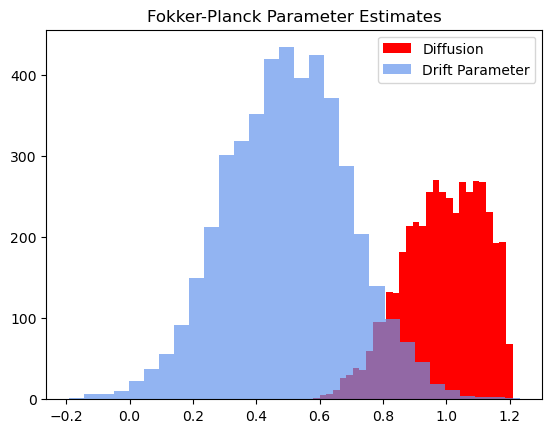

In [13]:
plt.hist(samples[:, 0], bins=30, label='Diffusion',color='red')
plt.hist(samples[:, 1], bins=30, label='Drift Parameter', alpha=0.7,color='cornflowerblue')
plt.legend()
plt.title('Fokker-Planck Parameter Estimates')
plt.show()

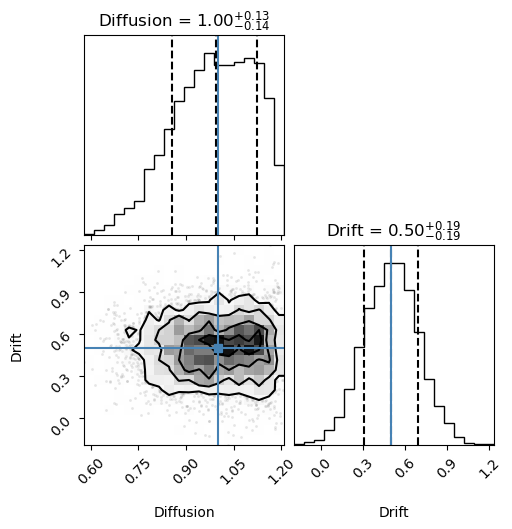

In [14]:
# Corner plot
import corner
fig = corner.corner(samples, labels=["Diffusion", "Drift"], truths=[true_D, true_drift], quantiles=[0.16, 0.5, 0.84],show_titles=True,title_kwargs={"fontsize": 12})
plt.show()


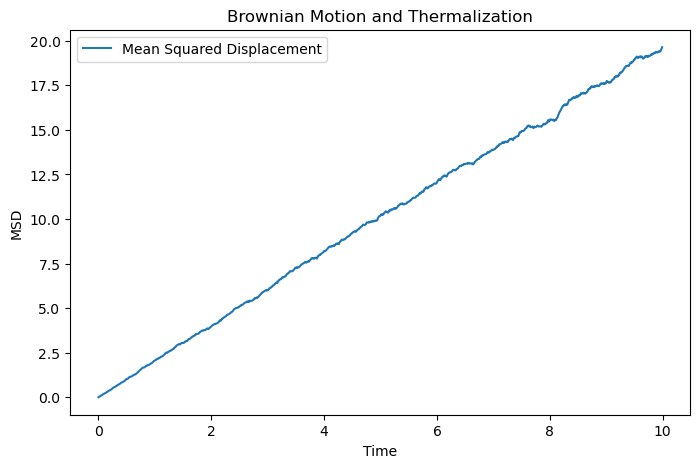

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def brownian_motion(num_particles, num_steps, dt, D):
    """
    Simulates Brownian motion for multiple particles.
    """
    x = np.zeros((num_particles, num_steps))
    for i in range(1, num_steps):
        dx = np.sqrt(2 * D * dt) * np.random.randn(num_particles)
        x[:, i] = x[:, i - 1] + dx
    return x

def compute_thermalization(x):
    """
    Computes the mean squared displacement (MSD) to analyze thermalization.
    """
    return np.mean(x**2, axis=0)

# Simulation parameters
num_particles = 1000  # Number of particles
num_steps = 1000  # Number of time steps
dt = 0.01  # Time step size
D = 1.0  # Diffusion coefficient

# Run simulation
x = brownian_motion(num_particles, num_steps, dt, D)
msd = compute_thermalization(x)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(np.arange(num_steps) * dt, msd, label='Mean Squared Displacement')
plt.xlabel('Time')
plt.ylabel('MSD')
plt.title('Brownian Motion and Thermalization')
plt.legend()
plt.show()


Escape Probability: 0.02275


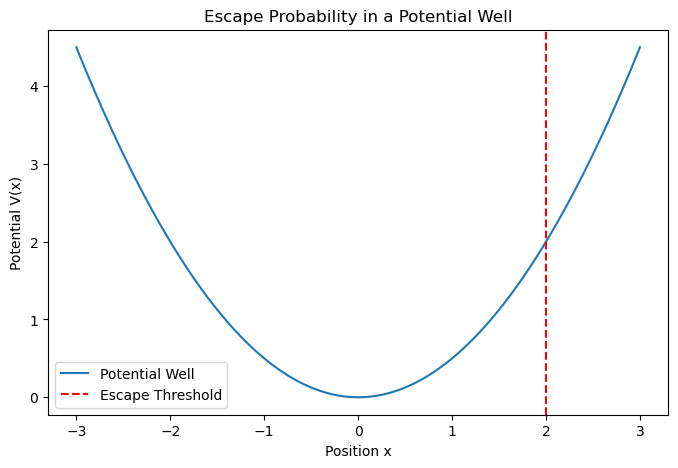

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

def potential(x):
    """
    Defines a potential well, e.g., a harmonic potential.
    """
    return 0.5 * x**2

def boltzmann_factor(x, beta):
    """
    Computes the Boltzmann factor for a given energy and inverse temperature beta.
    """
    return np.exp(-beta * potential(x))

def escape_probability(beta, x_threshold):
    """
    Computes the probability of escaping the potential well.
    """
    Z, _ = quad(lambda x: boltzmann_factor(x, beta), -np.inf, np.inf)
    P_escape, _ = quad(lambda x: boltzmann_factor(x, beta), x_threshold, np.inf)
    return P_escape / Z

# Parameters
beta = 1.0  # Inverse temperature
x_threshold = 2.0  # Escape threshold

# Compute probability
P_esc = escape_probability(beta, x_threshold)
print(f"Escape Probability: {P_esc:.5f}")

# Plot potential well
x_vals = np.linspace(-3, 3, 100)
p_vals = potential(x_vals)
plt.figure(figsize=(8, 5))
plt.plot(x_vals, p_vals, label='Potential Well')
plt.axvline(x_threshold, color='r', linestyle='--', label='Escape Threshold')
plt.xlabel('Position x')
plt.ylabel('Potential V(x)')
plt.title('Escape Probability in a Potential Well')
plt.legend()
plt.show()


/var/folders/1l/378_p_7n3w1cddmhf1mkkw2h0000gn/T/ipykernel_10269/2436000479.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P = np.exp(-potential(x) / (2 * D)) / np.trapz(np.exp(-potential(x) / (2 * D)), x)  # Equilibrium distribution
/var/folders/1l/378_p_7n3w1cddmhf1mkkw2h0000gn/T/ipykernel_10269/2436000479.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return P / np.trapz(P, x)  # Normalize probability


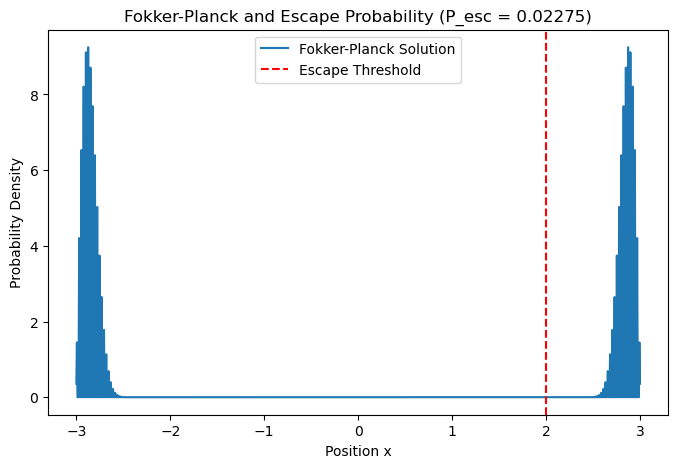

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import scipy.stats as stats

def potential(x):
    """
    Defines a potential well (harmonic for simplicity).
    """
    return 0.5 * x**2

def boltzmann_factor(x, beta):
    """
    Computes the Boltzmann factor for a given energy and inverse temperature beta.
    """
    return np.exp(-beta * potential(x))

def escape_probability(beta, x_threshold):
    """
    Computes the probability of escaping the potential well.
    """
    Z, _ = quad(lambda x: boltzmann_factor(x, beta), -np.inf, np.inf)
    P_escape, _ = quad(lambda x: boltzmann_factor(x, beta), x_threshold, np.inf)
    return P_escape / Z

def fokker_planck_solver(x, t, D, drift):
    """
    Solves the Fokker-Planck equation in a potential well.
    """
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    P = np.exp(-potential(x) / (2 * D)) / np.trapz(np.exp(-potential(x) / (2 * D)), x)  # Equilibrium distribution
    
    for _ in range(len(t) - 1):
        dPdx = np.gradient(P, dx)
        diffusion_term = D * np.gradient(dPdx, dx)
        drift_term = -np.gradient((drift - np.gradient(potential(x), dx)) * P, dx)
        P += dt * (diffusion_term + drift_term)
        P = np.maximum(P, 0)  # Ensure non-negative probability
    
    return P / np.trapz(P, x)  # Normalize probability

# Parameters
x = np.linspace(-3, 3, 1000)
t = np.linspace(0, 1, 100)
D = 1.0
beta = 1.0
x_threshold = 2.0

data = fokker_planck_solver(x, t, D, 0)
P_esc = escape_probability(beta, x_threshold)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(x, data, label='Fokker-Planck Solution')
plt.axvline(x_threshold, color='r', linestyle='--', label='Escape Threshold')
plt.xlabel('Position x')
plt.ylabel('Probability Density')
plt.title(f'Fokker-Planck and Escape Probability (P_esc = {P_esc:.5f})')
plt.legend()
plt.show()

/var/folders/1l/378_p_7n3w1cddmhf1mkkw2h0000gn/T/ipykernel_10269/4146792038.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sigma = np.trapz(J**2 / (D * P + 1e-10), x)  # Avoid division by zero
/var/folders/1l/378_p_7n3w1cddmhf1mkkw2h0000gn/T/ipykernel_10269/4146792038.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return P / np.trapz(P, x), np.array(entropy_production)  # Normalize probability
100%|██████████| 1000/1000 [00:45<00:00, 22.17it/s]


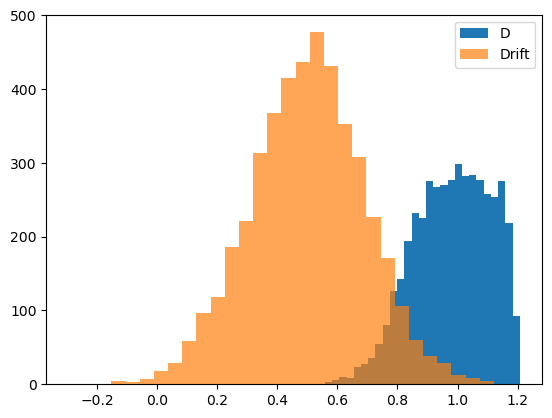

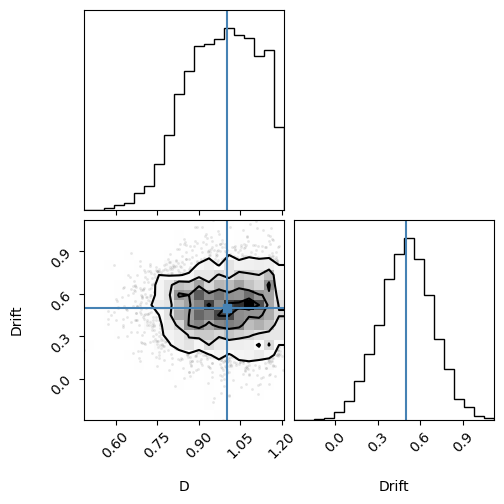

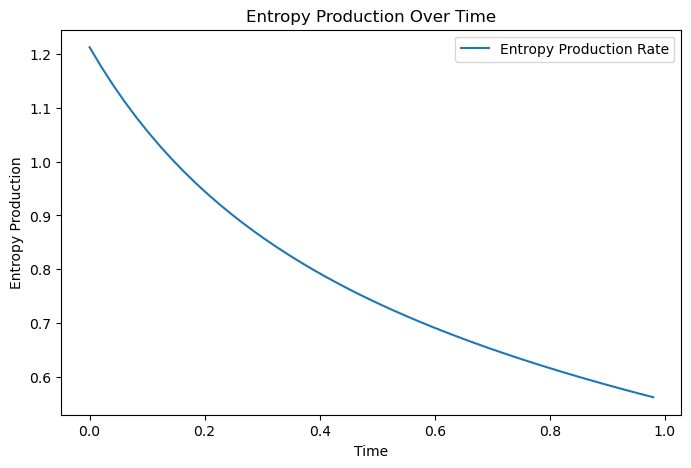

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
import emcee
import corner

def fokker_planck_solver(x, t, D, drift):
    """
    Solves the Fokker-Planck equation with drift and diffusion.
    Computes probability current and entropy production.
    """
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    P = np.exp(-x**2 / (2 * D)) / np.sqrt(2 * np.pi * D)  # Initial Gaussian distribution
    entropy_production = []
    
    for _ in range(len(t) - 1):
        dPdx = np.gradient(P, dx)
        diffusion_term = D * np.gradient(dPdx, dx)
        drift_term = -np.gradient(drift * P, dx)
        P += dt * (diffusion_term + drift_term)
        P = np.maximum(P, 0)  # Ensure non-negative probability
        
        # Compute probability current
        J = -D * dPdx + drift * P
        
        # Compute entropy production rate
        sigma = np.trapz(J**2 / (D * P + 1e-10), x)  # Avoid division by zero
        entropy_production.append(sigma)
    
    return P / np.trapz(P, x), np.array(entropy_production)  # Normalize probability

def log_likelihood(params, x, t, data):
    """
    Log-likelihood function for MCMC.
    """
    D, drift = params
    if D <= 0:  # Ensure physical constraints
        return -np.inf
    model, _ = fokker_planck_solver(x, t, D, drift)
    return np.sum(stats.norm.logpdf(data, model, 0.1))  # Assume small Gaussian noise

def run_mcmc(x, t, data, nwalkers=50, nsteps=1000):
    """
    Runs MCMC sampling to estimate D and drift.
    """
    ndim = 2
    initial_pos = [np.array([1.0, 0.0]) + 0.1 * np.random.randn(ndim) for _ in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(x, t, data))
    sampler.run_mcmc(initial_pos, nsteps, progress=True)
    return sampler

# Define space and time grids
x = np.linspace(-5, 5, 100)
t = np.linspace(0, 1, 50)

# True parameters for simulation
true_D = 1.0
true_drift = 0.5

data, entropy_production = fokker_planck_solver(x, t, true_D, true_drift)

# Run MCMC
sampler = run_mcmc(x, t, data)

# Plot results
samples = sampler.get_chain(discard=100, thin=10, flat=True)
plt.hist(samples[:, 0], bins=30, label='D')
plt.hist(samples[:, 1], bins=30, label='Drift', alpha=0.7)
plt.legend()
plt.show()

# Corner plot
fig = corner.corner(samples, labels=["D", "Drift"], truths=[true_D, true_drift])
plt.show()

# Plot entropy production over time
plt.figure(figsize=(8, 5))
plt.plot(t[:-1], entropy_production, label='Entropy Production Rate')
plt.xlabel('Time')
plt.ylabel('Entropy Production')
plt.title('Entropy Production Over Time')
plt.legend()
plt.show()

/var/folders/1l/378_p_7n3w1cddmhf1mkkw2h0000gn/T/ipykernel_10269/703220289.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sigma = np.trapz(J**2 / (D * P + 1e-10), x)  # Avoid division by zero
/var/folders/1l/378_p_7n3w1cddmhf1mkkw2h0000gn/T/ipykernel_10269/703220289.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return P / np.trapz(P, x), np.array(entropy_production), np.array(probability_current)  # Normalize probability
100%|██████████| 1000/1000 [00:46<00:00, 21.43it/s]


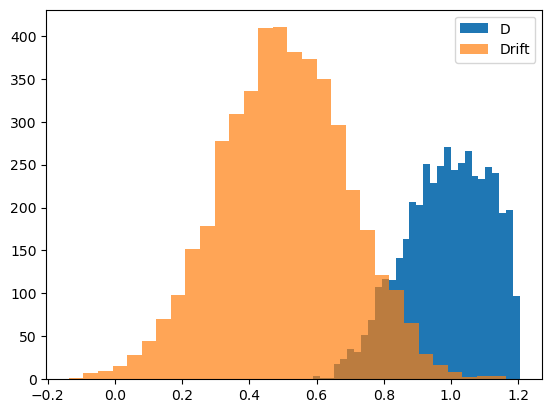

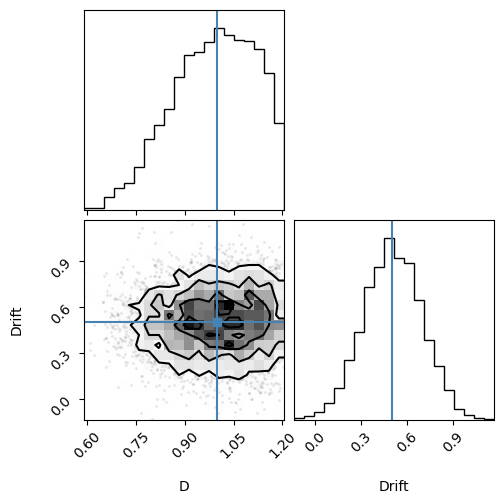

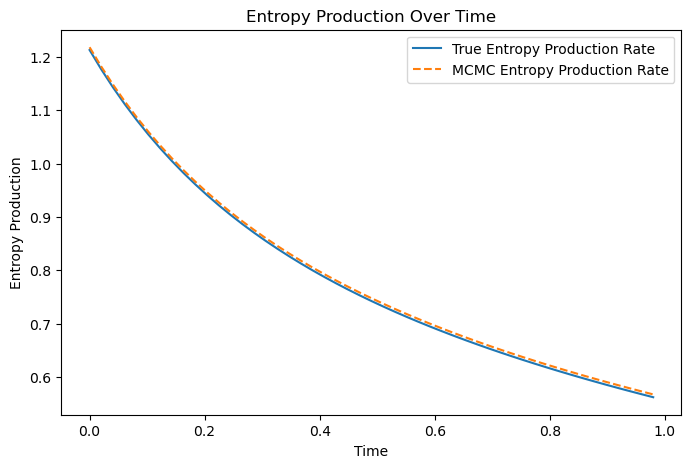

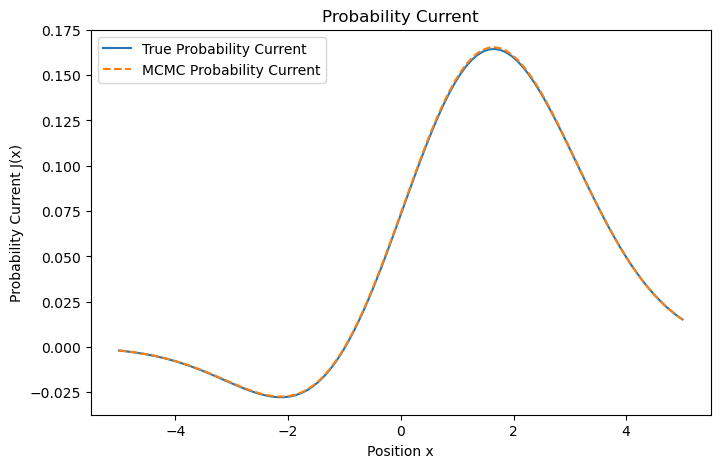

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
import emcee
import corner

def fokker_planck_solver(x, t, D, drift):
    """
    Solves the Fokker-Planck equation with drift and diffusion.
    Computes probability current and entropy production.
    """
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    P = np.exp(-x**2 / (2 * D)) / np.sqrt(2 * np.pi * D)  # Initial Gaussian distribution
    entropy_production = []
    probability_current = []
    
    for _ in range(len(t) - 1):
        dPdx = np.gradient(P, dx)
        diffusion_term = D * np.gradient(dPdx, dx)
        drift_term = -np.gradient(drift * P, dx)
        P += dt * (diffusion_term + drift_term)
        P = np.maximum(P, 0)  # Ensure non-negative probability
        
        # Compute probability current
        J = -D * dPdx + drift * P
        probability_current.append(J)
        
        # Compute entropy production rate
        sigma = np.trapz(J**2 / (D * P + 1e-10), x)  # Avoid division by zero
        entropy_production.append(sigma)
    
    return P / np.trapz(P, x), np.array(entropy_production), np.array(probability_current)  # Normalize probability

def log_likelihood(params, x, t, data):
    """
    Log-likelihood function for MCMC.
    """
    D, drift = params
    if D <= 0:  # Ensure physical constraints
        return -np.inf
    model, _, _ = fokker_planck_solver(x, t, D, drift)
    return np.sum(stats.norm.logpdf(data, model, 0.1))  # Assume small Gaussian noise

def run_mcmc(x, t, data, nwalkers=50, nsteps=1000):
    """
    Runs MCMC sampling to estimate D and drift.
    """
    ndim = 2
    initial_pos = [np.array([1.0, 0.0]) + 0.1 * np.random.randn(ndim) for _ in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(x, t, data))
    sampler.run_mcmc(initial_pos, nsteps, progress=True)
    return sampler

# Define space and time grids
x = np.linspace(-5, 5, 100)
t = np.linspace(0, 1, 50)

# True parameters for simulation
true_D = 1.0
true_drift = 0.5

data, entropy_production, probability_current = fokker_planck_solver(x, t, true_D, true_drift)

# Run MCMC
sampler = run_mcmc(x, t, data)

# Extract MCMC results
samples = sampler.get_chain(discard=100, thin=10, flat=True)
D_mcmc, drift_mcmc = np.median(samples, axis=0)

# Compute entropy production and probability current using MCMC results
_, entropy_production_mcmc, probability_current_mcmc = fokker_planck_solver(x, t, D_mcmc, drift_mcmc)

# Plot MCMC parameter distributions
plt.hist(samples[:, 0], bins=30, label='D')
plt.hist(samples[:, 1], bins=30, label='Drift', alpha=0.7)
plt.legend()
plt.show()

# Corner plot
fig = corner.corner(samples, labels=["D", "Drift"], truths=[true_D, true_drift])
plt.show()

# Plot entropy production over time
plt.figure(figsize=(8, 5))
plt.plot(t[:-1], entropy_production, label='True Entropy Production Rate')
plt.plot(t[:-1], entropy_production_mcmc, '--', label='MCMC Entropy Production Rate')
plt.xlabel('Time')
plt.ylabel('Entropy Production')
plt.title('Entropy Production Over Time')
plt.legend()
plt.show()

# Plot probability current
plt.figure(figsize=(8, 5))
plt.plot(x, probability_current[-1], label='True Probability Current')
plt.plot(x, probability_current_mcmc[-1], '--', label='MCMC Probability Current')
plt.xlabel('Position x')
plt.ylabel('Probability Current J(x)')
plt.title('Probability Current')
plt.legend()
plt.show()


/var/folders/1l/378_p_7n3w1cddmhf1mkkw2h0000gn/T/ipykernel_10269/21841568.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sigma = np.trapz(J**2 / (D * P + 1e-10), x)  # Avoid division by zero
/var/folders/1l/378_p_7n3w1cddmhf1mkkw2h0000gn/T/ipykernel_10269/21841568.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return P / np.trapz(P, x), np.array(entropy_production), np.array(probability_current)  # Normalize probability
100%|██████████| 1000/1000 [00:48<00:00, 20.65it/s]


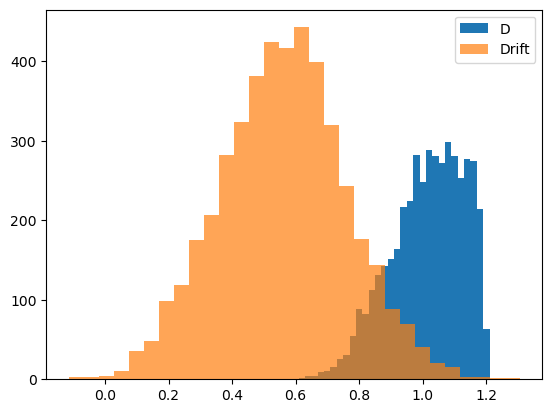

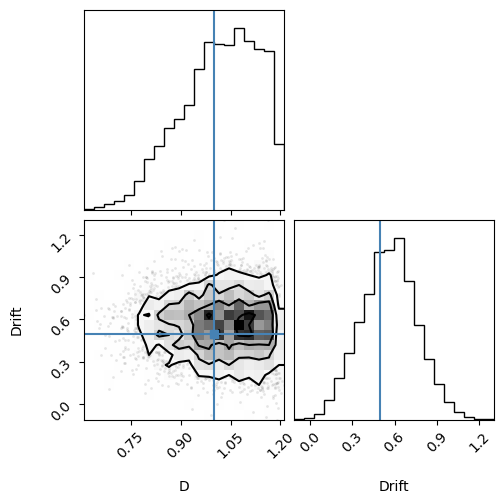

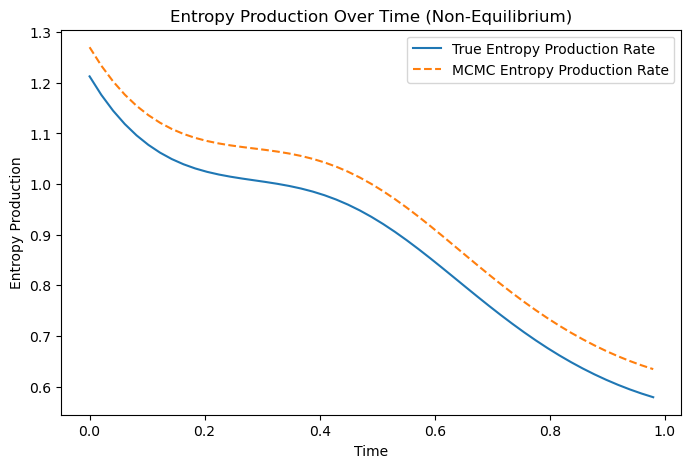

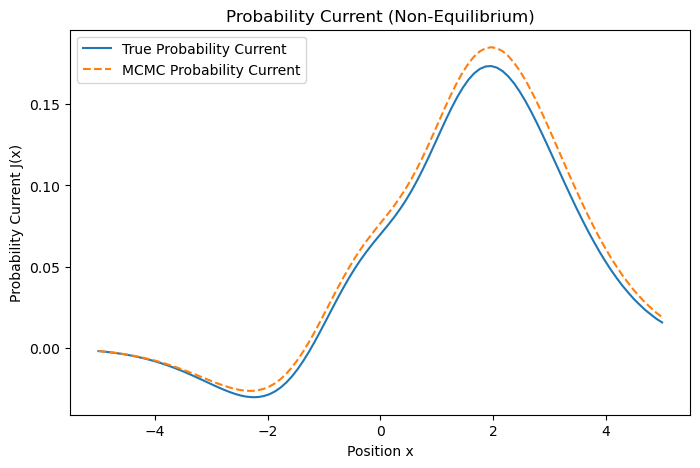

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
import emcee
import corner

def fokker_planck_solver(x, t, D, drift, forcing=None):
    """
    Solves the Fokker-Planck equation with drift, diffusion, and external forcing.
    Computes probability current and entropy production.
    """
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    P = np.exp(-x**2 / (2 * D)) / np.sqrt(2 * np.pi * D)  # Initial Gaussian distribution
    entropy_production = []
    probability_current = []
    
    for i in range(len(t) - 1):
        dPdx = np.gradient(P, dx)
        diffusion_term = D * np.gradient(dPdx, dx)
        drift_term = -np.gradient(drift * P, dx)
        external_force = forcing(x, t[i]) if forcing else 0
        P += dt * (diffusion_term + drift_term + external_force * P)
        P = np.maximum(P, 0)  # Ensure non-negative probability
        
        # Compute probability current
        J = -D * dPdx + drift * P
        probability_current.append(J)
        
        # Compute entropy production rate
        sigma = np.trapz(J**2 / (D * P + 1e-10), x)  # Avoid division by zero
        entropy_production.append(sigma)
    
    return P / np.trapz(P, x), np.array(entropy_production), np.array(probability_current)  # Normalize probability

def log_likelihood(params, x, t, data):
    """
    Log-likelihood function for MCMC.
    """
    D, drift = params
    if D <= 0:  # Ensure physical constraints
        return -np.inf
    model, _, _ = fokker_planck_solver(x, t, D, drift)
    return np.sum(stats.norm.logpdf(data, model, 0.1))  # Assume small Gaussian noise

def run_mcmc(x, t, data, nwalkers=50, nsteps=1000):
    """
    Runs MCMC sampling to estimate D and drift.
    """
    ndim = 2
    initial_pos = [np.array([1.0, 0.0]) + 0.1 * np.random.randn(ndim) for _ in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(x, t, data))
    sampler.run_mcmc(initial_pos, nsteps, progress=True)
    return sampler

# Define space and time grids
x = np.linspace(-5, 5, 100)
t = np.linspace(0, 1, 50)

# External forcing to drive system out of equilibrium
def non_eq_forcing(x, t):
    return np.sin(2 * np.pi * t) * np.exp(-x**2)

# True parameters for simulation
true_D = 1.0
true_drift = 0.5

data, entropy_production, probability_current = fokker_planck_solver(x, t, true_D, true_drift, forcing=non_eq_forcing)

# Run MCMC
sampler = run_mcmc(x, t, data)

# Extract MCMC results
samples = sampler.get_chain(discard=100, thin=10, flat=True)
D_mcmc, drift_mcmc = np.median(samples, axis=0)

# Compute entropy production and probability current using MCMC results
_, entropy_production_mcmc, probability_current_mcmc = fokker_planck_solver(x, t, D_mcmc, drift_mcmc, forcing=non_eq_forcing)

# Plot MCMC parameter distributions
plt.hist(samples[:, 0], bins=30, label='D')
plt.hist(samples[:, 1], bins=30, label='Drift', alpha=0.7)
plt.legend()
plt.show()

# Corner plot
fig = corner.corner(samples, labels=["D", "Drift"], truths=[true_D, true_drift])
plt.show()

# Plot entropy production over time
plt.figure(figsize=(8, 5))
plt.plot(t[:-1], entropy_production, label='True Entropy Production Rate')
plt.plot(t[:-1], entropy_production_mcmc, '--', label='MCMC Entropy Production Rate')
plt.xlabel('Time')
plt.ylabel('Entropy Production')
plt.title('Entropy Production Over Time (Non-Equilibrium)')
plt.legend()
plt.show()

# Plot probability current
plt.figure(figsize=(8, 5))
plt.plot(x, probability_current[-1], label='True Probability Current')
plt.plot(x, probability_current_mcmc[-1], '--', label='MCMC Probability Current')
plt.xlabel('Position x')
plt.ylabel('Probability Current J(x)')
plt.title('Probability Current (Non-Equilibrium)')
plt.legend()
plt.show()


/var/folders/1l/378_p_7n3w1cddmhf1mkkw2h0000gn/T/ipykernel_10269/1953165143.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sigma = np.trapz(J**2 / (D * P + 1e-10), x)  # Avoid division by zero
/var/folders/1l/378_p_7n3w1cddmhf1mkkw2h0000gn/T/ipykernel_10269/1953165143.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return P / np.trapz(P, x), np.array(entropy_production), np.array(probability_current)  # Normalize probability
100%|██████████| 1000/1000 [01:03<00:00, 15.83it/s]


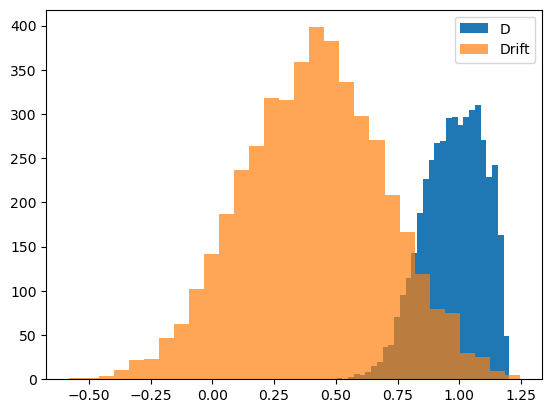

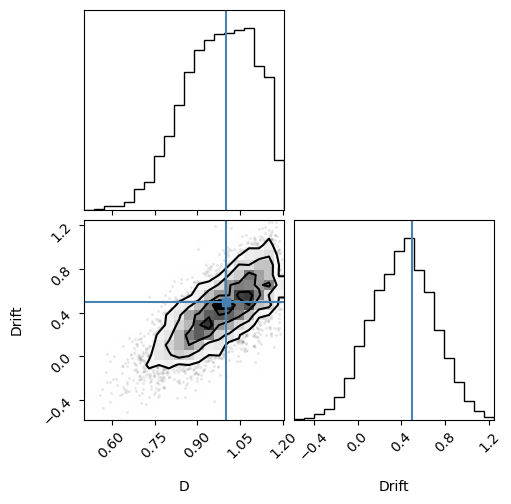

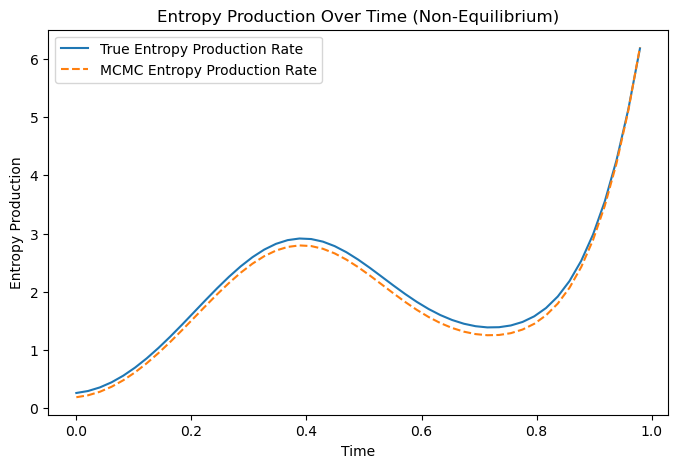

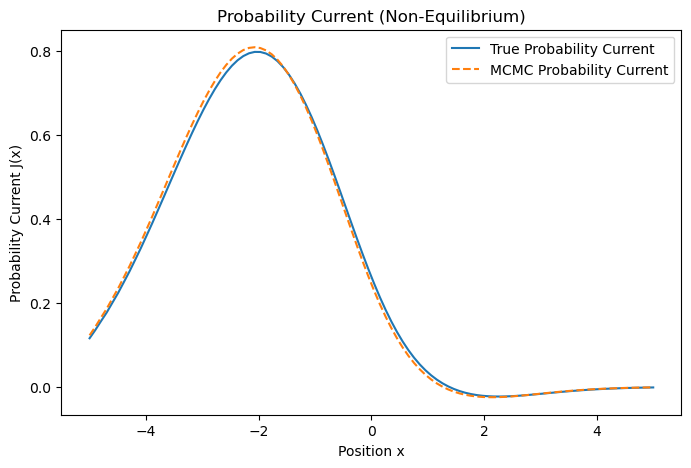

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
import emcee
import corner

def fokker_planck_solver(x, t, D, drift, potential_well, forcing=None):
    """
    Solves the Fokker-Planck equation with drift, diffusion, and external forcing.
    Computes probability current and entropy production.
    """
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    P = np.exp(-x**2 / (2 * D)) / np.sqrt(2 * np.pi * D)  # Initial Gaussian distribution
    entropy_production = []
    probability_current = []
    
    for i in range(len(t) - 1):
        dPdx = np.gradient(P, dx)
        diffusion_term = D * np.gradient(dPdx, dx)
        potential_force = -np.gradient(potential_well(x, t[i]), dx)
        drift_term = -np.gradient(drift * P, dx) + potential_force * P
        external_force = forcing(x, t[i]) if forcing else 0
        P += dt * (diffusion_term + drift_term + external_force * P)
        P = np.maximum(P, 0)  # Ensure non-negative probability
        
        # Compute probability current
        J = -D * dPdx + (drift + potential_force) * P
        probability_current.append(J)
        
        # Compute entropy production rate
        sigma = np.trapz(J**2 / (D * P + 1e-10), x)  # Avoid division by zero
        entropy_production.append(sigma)
    
    return P / np.trapz(P, x), np.array(entropy_production), np.array(probability_current)  # Normalize probability

def time_dependent_potential(x, t):
    """
    Defines a time-dependent potential well.
    """
    return 0.5 * (x**2) * (1 + 0.5 * np.sin(2 * np.pi * t))

def log_likelihood(params, x, t, data):
    """
    Log-likelihood function for MCMC.
    """
    D, drift = params
    if D <= 0:  # Ensure physical constraints
        return -np.inf
    model, _, _ = fokker_planck_solver(x, t, D, drift, time_dependent_potential)
    return np.sum(stats.norm.logpdf(data, model, 0.1))  # Assume small Gaussian noise

def run_mcmc(x, t, data, nwalkers=50, nsteps=1000):
    """
    Runs MCMC sampling to estimate D and drift.
    """
    ndim = 2
    initial_pos = [np.array([1.0, 0.0]) + 0.1 * np.random.randn(ndim) for _ in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(x, t, data))
    sampler.run_mcmc(initial_pos, nsteps, progress=True)
    return sampler

# Define space and time grids
x = np.linspace(-5, 5, 100)
t = np.linspace(0, 1, 50)

# External forcing to drive system out of equilibrium
def non_eq_forcing(x, t):
    return np.sin(2 * np.pi * t) * np.exp(-x**2)

# True parameters for simulation
true_D = 1.0
true_drift = 0.5

data, entropy_production, probability_current = fokker_planck_solver(x, t, true_D, true_drift, time_dependent_potential, forcing=non_eq_forcing)

# Run MCMC
sampler = run_mcmc(x, t, data)

# Extract MCMC results
samples = sampler.get_chain(discard=100, thin=10, flat=True)
D_mcmc, drift_mcmc = np.median(samples, axis=0)

# Compute entropy production and probability current using MCMC results
_, entropy_production_mcmc, probability_current_mcmc = fokker_planck_solver(x, t, D_mcmc, drift_mcmc, time_dependent_potential, forcing=non_eq_forcing)

# Plot MCMC parameter distributions
plt.hist(samples[:, 0], bins=30, label='D')
plt.hist(samples[:, 1], bins=30, label='Drift', alpha=0.7)
plt.legend()
plt.show()

# Corner plot
fig = corner.corner(samples, labels=["D", "Drift"], truths=[true_D, true_drift])
plt.show()

# Plot entropy production over time
plt.figure(figsize=(8, 5))
plt.plot(t[:-1], entropy_production, label='True Entropy Production Rate')
plt.plot(t[:-1], entropy_production_mcmc, '--', label='MCMC Entropy Production Rate')
plt.xlabel('Time')
plt.ylabel('Entropy Production')
plt.title('Entropy Production Over Time (Non-Equilibrium)')
plt.legend()
plt.show()

# Plot probability current
plt.figure(figsize=(8, 5))
plt.plot(x, probability_current[-1], label='True Probability Current')
plt.plot(x, probability_current_mcmc[-1], '--', label='MCMC Probability Current')
plt.xlabel('Position x')
plt.ylabel('Probability Current J(x)')
plt.title('Probability Current (Non-Equilibrium)')
plt.legend()
plt.show()